# Model Analysis

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


In [9]:
tfidf_preds = pd.read_csv("../results/tfidf/predictions.csv")
bilstm_preds = pd.read_csv("../results/bilstm/predictions.csv")
distil_preds = pd.read_csv("../results/distilbert/predictions.csv")
tfidf_preds.columns,bilstm_preds.columns,distil_preds.columns

(Index(['post_id', 'source', 'text', 'label', 'predicted', 'correct'], dtype='object'),
 Index(['post_id', 'source', 'text', 'label', 'encoded_label', 'encoded',
        'predicted_label'],
       dtype='object'),
 Index(['text', 'label', 'predicted'], dtype='object'))

In [10]:
bilstm_preds["predicted"] = bilstm_preds["predicted_label"]

In [ ]:
for df in [tfidf_preds, bilstm_preds, distil_preds]:
    df["correct"] = df["label"] == df["predicted"]

In [13]:
df[df.correct]

,text,label,predicted,correct
0,<user> men can not be raped can not be abused ...,normal,normal,True
1,<user> you are missing an essential premise wh...,normal,normal,True
2,<user> <user> why are you repeating yourself a...,offensive,offensive,True
5,an these nigger biches look like godzilla nasty,hatespeech,hatespeech,True
6,yeah humnh what how do i use this app i ’ m al...,offensive,offensive,True
...,...,...,...,...
1917,i ’ m a ghetto genius i ’ ll slap the shit out...,offensive,offensive,True
1918,i fucking hate wokeoids bro legit subhuman degens,offensive,offensive,True
1919,we hate islam and we will mock your paedophile...,hatespeech,hatespeech,True
1921,4 chan is retarded and so are you,offensive,offensive,True


In [14]:
with open("../results/tfidf/metrics.json") as f:
    tfidf_metrics = json.load(f)

with open("../results/bilstm/metrics.json") as f:
    bilstm_metrics = json.load(f)

with open("../results/distilbert/metrics.json") as f:
    distil_metrics = json.load(f)

In [15]:
comparison = pd.DataFrame({
    "Model": ["TF-IDF", "BiLSTM", "DistilBERT"],
    "Accuracy": [
        tfidf_metrics["accuracy"],
        bilstm_metrics["accuracy"],
        distil_metrics["accuracy"]
    ],
    "Macro-F1": [
        tfidf_metrics["macro avg"]["f1-score"],
        bilstm_metrics["macro avg"]["f1-score"],
        distil_metrics["macro avg"]["f1-score"]
    ],
    "Hate F1": [
        tfidf_metrics["hatespeech"]["f1-score"],
        bilstm_metrics["hatespeech"]["f1-score"],
        distil_metrics["hatespeech"]["f1-score"]
    ],
    "Normal F1": [
        tfidf_metrics["normal"]["f1-score"],
        bilstm_metrics["normal"]["f1-score"],
        distil_metrics["normal"]["f1-score"]
    ],
    "Offensive F1": [
        tfidf_metrics["offensive"]["f1-score"],
        bilstm_metrics["offensive"]["f1-score"],
        distil_metrics["offensive"]["f1-score"]
    ]
})

comparison

,Model,Accuracy,Macro-F1,Hate F1,Normal F1,Offensive F1
0,TF-IDF,0.648129,0.638880,0.730864,0.689922,0.495853
1,BiLSTM,0.586798,0.576626,0.648897,0.645084,0.435897
2,DistilBERT,0.663721,0.656085,0.752756,0.705314,0.510186


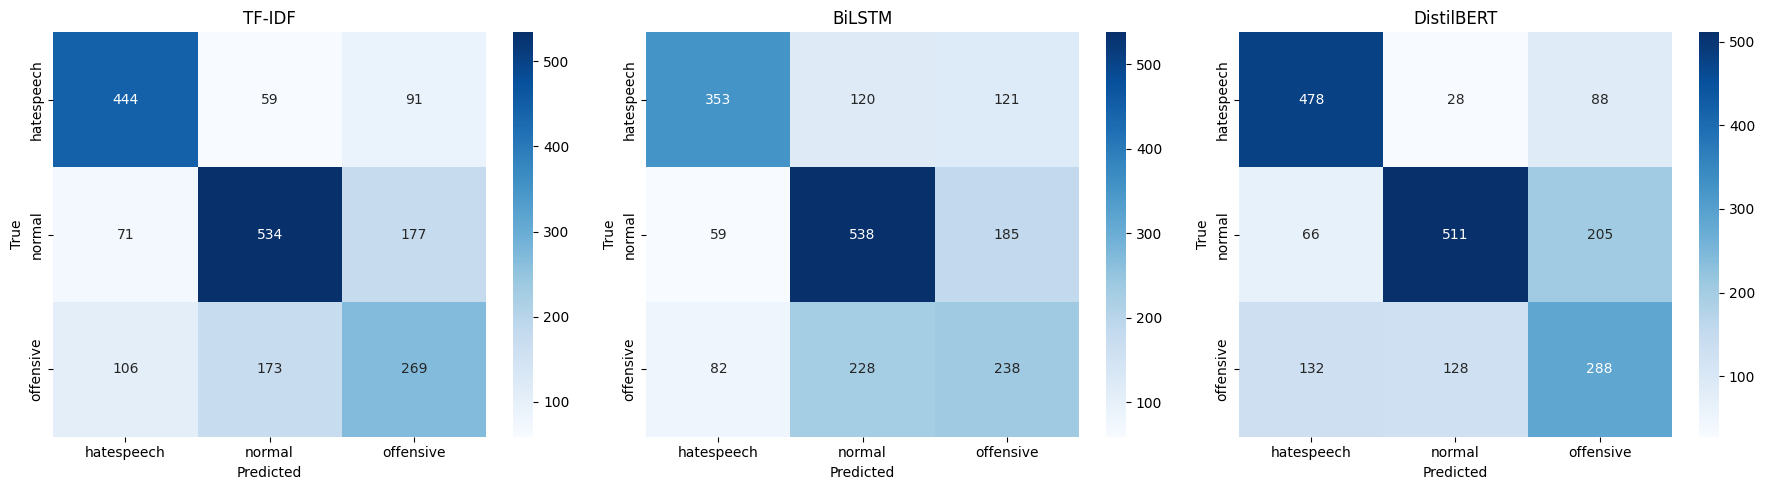

In [22]:
labels = ["hatespeech","normal","offensive"]
def plot_cm(df, title, ax):
    cm = confusion_matrix(df["label"], df["predicted"], labels=labels)
    sns.heatmap(cm, annot=True, fmt="d",xticklabels=labels,yticklabels=labels,ax=ax, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

fig, axes = plt.subplots(1,3,figsize=(18,5))

plot_cm(tfidf_preds, "TF-IDF", axes[0])
plot_cm(bilstm_preds, "BiLSTM", axes[1])
plot_cm(distil_preds, "DistilBERT", axes[2])

plt.tight_layout()
plt.savefig("../figures/conf_all.png",dpi=300,bbox_inches="tight")
plt.show()


In [18]:
summary = pd.DataFrame({
    "Model": ["TF-IDF","BiLSTM","DistilBERT"],
    "Total Samples": [len(tfidf_preds),len(bilstm_preds),len(distil_preds)],
    "Errors": [
        (~tfidf_preds["correct"]).sum(),
        (~bilstm_preds["correct"]).sum(),
        (~distil_preds["correct"]).sum()
    ]
})

summary

,Model,Total Samples,Errors
0,TF-IDF,1924,677
1,BiLSTM,1924,795
2,DistilBERT,1924,647


In [ ]:
tfidf_errors = set(tfidf_preds[~tfidf_preds.correct].index)
bilstm_errors = set(bilstm_preds[~bilstm_preds.correct].index)
distil_errors = set(distil_preds[~distil_preds.correct].index)

print("TF-IDF & BiLSTM:", len(tfidf_errors & bilstm_errors))
print("TF-IDF & DistilBERT:", len(tfidf_errors & distil_errors))
print("BiLSTM & DistilBERT:", len(bilstm_errors & distil_errors))

TF-IDF & BiLSTM: 499
TF-IDF & DistilBERT: 440
BiLSTM & DistilBERT: 415


DistilBERT substantially improves macro-F1 and reduces hate/offensive confusion compared to both TF-IDF and BiLSTM.